In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split #Splitting data for model training
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import *

## Load Data

In [5]:
df_orig = pd.read_csv('sampleOriginationCombined.csv', low_memory=False)
df_perf = pd.read_csv('SamplePerformanceCombinedSummary.csv', low_memory = False)

In [19]:
print('df_orig ',df_orig.shape)
print('df_perf ',df_perf.shape)

df_orig  (1112500, 32)
df_perf  (1109138, 24)


## Create Loss Target Variable

In [16]:
df_perf['loss_target'] = df_perf['max_actual_loss']
df_perf.loc[df_perf['max_actual_loss'] > 0, 'loss_target'] = 1

In [17]:
df_perf['loss_target'].value_counts()

0    1106377
1       2761
Name: loss_target, dtype: int64

## Prepare Main DataFrame

In [43]:
df = pd.merge(df_orig, df_perf[['id_loan','loss_target']], on='id_loan', how='inner')
print('df ',df.shape)

df  (1109138, 33)


In [44]:
df = df[df['Year']!=2021]
df.shape

(1096639, 33)

In [26]:
df.dtypes

fico                 int64
dt_first_pi          int64
flag_fthb           object
dt_matr              int64
cd_msa               int64
mi_pct               int64
cnt_units            int64
occpy_sts           object
cltv                 int64
dti                  int64
orig_upb             int64
ltv                  int64
int_rt             float64
channel             object
ppmt_pnlty          object
prod_type           object
st                  object
prop_type           object
zipcode              int64
id_loan             object
loan_purpose        object
orig_loan_term       int64
cnt_borr             int64
seller_name         object
servicer_name       object
flag_sc             object
id_preharp          object
indicator           object
harp_indicator      object
property_method      int64
interest_only       object
Year                 int64
loss_target          int64
dtype: object

Preprocess dataframe

Remove unnecessary features: 'zipcode','id_loan','id_preharp','seller_name','servicer_name'

In [47]:
df = df.drop(columns=['zipcode','id_loan','id_preharp','seller_name','servicer_name'])

In [52]:
unused_columns = ['id_loan']
lbl_dict = {}
for c in df.columns:
    
    if c == "mi_pct": 
        df.loc[df[c] == '999', c] = np.nan
    elif c == "cnt_units": 
        df.loc[df[c] == '99', c] = np.nan
    
    elif c == "cd_msa": 
        df[c] =df[c].fillna(0)
    
    elif c == "ppmt_pnlty": 
        df[c] =df[c].map({'N':0,'Y':1})
    
    if (df[c].dtype=='object' or c == "zipcode" or c =="cd_msa")and c not in unused_columns: 
        lbl = LabelEncoder()
        lbl.fit(list(df[c].values))
        lbl_dict[c] = lbl
        df[c] = lbl.transform(list(df[c].values))

In [60]:
df.isna().sum()

fico               0
dt_first_pi        0
flag_fthb          0
dt_matr            0
cd_msa             0
mi_pct             0
cnt_units          0
occpy_sts          0
cltv               0
dti                0
orig_upb           0
ltv                0
int_rt             0
channel            0
ppmt_pnlty         0
prod_type          0
st                 0
prop_type          0
loan_purpose       0
orig_loan_term     0
cnt_borr           0
flag_sc            0
indicator          0
harp_indicator     0
property_method    0
interest_only      0
Year               0
loss_target        0
dtype: int64

In [65]:
df.shape

(1096639, 28)

## Split Data into Train and Test

In [96]:
train = df[df['Year']<2018]
test = df[df['Year']>=2018]
X_train = train[train.columns.drop('loss_target')]
X_test = test[test.columns.drop('loss_target')]
y_train = train[['loss_target']]
y_test = test[['loss_target']]
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (946639, 27) (946639, 1)
Test (150000, 27) (150000, 1)


## Standardize Features

In [99]:
def scale(df):
    scaled = StandardScaler().fit_transform(df)
    return scaled
X_train, X_test =  scale(X_train), scale(X_test)

## Trying Anomaly Detection Methods for Detecting "Bad Loans"

### 1. One-Class Support Vector Machines

The algorithm learns a soft boundary in order to cluster the normal data instances using the training set, and then, using the testing instance, it tunes itself to identify the abnormalities that fall outside the learned region.

In [106]:
from sklearn.svm import OneClassSVM

In [107]:
# define outlier detection model
model = OneClassSVM(gamma='scale', nu=0.01)
# fit on majority class

model.fit(X_train)
# detect outliers in the test set
yhat = model.predict(X_test)
yhat = ((yhat*-1)+1)*0.5
yhat_train = model.predict(X_train)
yhat_train = ((yhat_train*-1)+1)*0.5

In [109]:
print('Training\n Balanced Accuracy',balanced_accuracy_score(y_train,y_pred_train_iso),
         'ROC AUC:',roc_auc_score(y_train,yhat_train), 'F1 Score',f1_score(y_train,yhat_train),'\n',
         confusion_matrix(y_train,yhat_train))    
print('Testing\n Balanced Accuracy',balanced_accuracy_score(y_test, y_pred_future_iso),
         'ROC AUC:',roc_auc_score(y_test, yhat), 'F1 Score',f1_score(y_test, yhat),'\n',
         confusion_matrix(y_test, yhat))

Training
 Balanced Accuracy 0.49904123348130935 ROC AUC: 0.49752883148927274 F1 Score 0.002289639381797367 
 [[934424   9458]
 [  2743     14]]
Testing
 Balanced Accuracy 0.49865663084348916 ROC AUC: 0.6952918744499852 F1 Score 0.00024363503471799247 
 [[133584  16412]
 [     2      2]]


#### From above, accuracy for predicting test data is very low around 0.5, and F1 score is almost 0, which means we failed to detect outliers to see how well they match with the bad loans.

### 2. Isolation Forest¶

In [37]:
from sklearn.ensemble import IsolationForest

In [88]:
iso_clf = IsolationForest(random_state=42,contamination=float(0.003))
iso_clf.fit(X_train)
y_pred_train_iso = iso_clf.predict(X_train)
y_pred_train_iso = ((y_pred_train_iso*-1)+1)*0.5

y_pred_future_iso = iso_clf.predict(X_test)
y_pred_future_iso = ((y_pred_future_iso*-1)+1)*0.5

In [85]:
print('Training\n Balanced Accuracy',balanced_accuracy_score(y_train,y_pred_train_iso),
         'ROC AUC:',roc_auc_score(y_train,y_pred_train_iso), 'F1 Score',f1_score(y_train,y_pred_train_iso),'\n',
         confusion_matrix(y_train,y_pred_train_iso))    
print('Testing\n Balanced Accuracy',balanced_accuracy_score(y_test, y_pred_future_iso),
         'ROC AUC:',roc_auc_score(y_test, y_pred_future_iso), 'F1 Score',f1_score(y_test, y_pred_future_iso),'\n',
         confusion_matrix(y_test, y_pred_future_iso))

Training
 Balanced Accuracy 0.497326218796475 ROC AUC: 0.49732621879647493 F1 Score 0.00535818765974482 
 [[849479  94403]
 [  2496    261]]
Testing
 Balanced Accuracy 0.6598042614469719 ROC AUC: 0.6598042614469719 F1 Score 0.00014779781259237362 
 [[122938  27058]
 [     2      2]]


#### From above, accuracy for predicting test data is very low around 0.66, and F1 score is almost 0, which means we failed to detect outliers to see how well they match with the bad loans.

### 3. Minimum Covariance Determinant

In [95]:
from sklearn.covariance import EllipticEnvelope

In [100]:
model = EllipticEnvelope(contamination=0.01)

# fit on majority class
trainX = train[train['loss_target']==0]
trainX = scale(trainX[trainX.columns.drop('loss_target')])
model.fit(trainX)

EllipticEnvelope(assume_centered=False, contamination=0.01, random_state=None,
                 store_precision=True, support_fraction=None)

In [104]:
# detect outliers in the test set
yhat_train = model.predict(X_train)
yhat_train = ((yhat_train*-1)+1)*0.5
yhat = model.predict(X_test)
yhat = ((yhat*-1)+1)*0.5

In [105]:
print('Training\n Balanced Accuracy',balanced_accuracy_score(y_train,y_pred_train_iso),
         'ROC AUC:',roc_auc_score(y_train,yhat_train), 'F1 Score',f1_score(y_train,yhat_train),'\n',
         confusion_matrix(y_train,yhat_train))    
print('Testing\n Balanced Accuracy',balanced_accuracy_score(y_test, y_pred_future_iso),
         'ROC AUC:',roc_auc_score(y_test, yhat), 'F1 Score',f1_score(y_test, yhat),'\n',
         confusion_matrix(y_test, yhat))

Training
 Balanced Accuracy 0.49904123348130935 ROC AUC: 0.5062699671957314 F1 Score 0.010156441969039233 
 [[934492   9390]
 [  2695     62]]
Testing
 Balanced Accuracy 0.49865663084348916 ROC AUC: 0.396963919037841 F1 Score 0.0 
 [[119086  30910]
 [     4      0]]


#### From above, correctness is even worse than the IForest method, which means we failed to detect outliers to see how well they match with the bad loans. This method assumes the features are normally distributed, which is far from reality.

#### Since we have no success identifying bad loans with anomaly detection methods taking considerations of all the features we have with a time span of from 1999 to 2020, we narrow down the data to reduce noise, and try to look at one feature at a time: 

### 4. Detector Using simple moving average (SMA) / low-pass filter

In [110]:
from numpy import linspace, loadtxt, ones, convolve
import collections
from itertools import  count

In [156]:

def moving_average(data, window_size):
    """ Computes moving average using discrete linear convolution of two one dimensional sequences. 
    Args:
    -----
            data (pandas.Series): independent variable 
            window_size (int): rolling window size

    Returns:
    --------
            ndarray of linear convolution

    References:
    ------------
    [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
    [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

    """
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')


def explain_anomalies(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using stationary standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value)) 
        containing information about the points indentified as anomalies

    """
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return {'standard_deviation': round(std, 3), 
            'anomalies_dict': collections.OrderedDict([(index, y_i) for 
                                                       index, y_i, avg_i in zip(count(), y, avg) 
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}


def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value)) 
        containing information about the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = residual.rolling(window_size).std()
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan, 
                                  testing_std_as_df.loc[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3), 
            'anomalies_dict': collections.OrderedDict([(index, y_i) 
                                                       for index, y_i, avg_i, rs_i in zip(count(), 
                                                                                           y, avg_list, rolling_std) 
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}


# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(x, y, window_size, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False,xlim=None,ylim=None):
    """ Helps in generating the plot and flagging the anamolies. 
        Supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch 
        between the two.
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
        applying_rolling_std (boolean): True/False for using rolling vs stationary standard deviation
    """
    plt.figure(figsize=(24, 7))
    plt.subplot(1, 2, 1)
    plt.plot(x, y, "k.")
    #y_av = moving_average(y, window_size)
    #plt.plot(x, y_av, color='green')
    if xlim:
        plt.xlim(xlim, ylim)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)

    
    x_anomaly = x[list(events['anomalies_dict'].keys())]  #np.fromiter(events['anomalies_dict'].keys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = y[list(events['anomalies_dict'].keys())]#np.fromiter(events['anomalies_dict'].values(), dtype=float, count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

    # add grid and lines and enable the plot
    plt.grid(True)
    
    plt.show()

In [214]:
def plot_compare(x, y, df, window_size, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis",
                 applying_rolling_std=False,xlim1=None,xlim2=None,ylim1=None,ylim2=None):
 
    plt.figure(figsize=(24, 12))
    ## plot1
    plt.subplot(1, 2, 1)
    
    X=df[x]
    Y=df[y]
    text_xlabel=X.name
    text_ylabel=Y.name    
    
    plt.plot(X,Y, "k.")
    #y_av = moving_average(y, window_size)
    #plt.plot(X, Y, color='green')
    if xlim1:
        plt.xlim(xlim1, xlim2)
    if ylim1:
        plt.ylim(ylim1, ylim2)

    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    # Query for the anomalies and plot the same
   
    x_anomaly = df[df['loss_target']==1][x]
    y_anomaly = df[df['loss_target']==1][y]
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)
    plt.title("Actual Data",fontsize= 25)
    plt.grid(True)
    ## plot2
    plt.subplot(1, 2, 2)
    plt.plot(X, Y, "k.")
    if xlim1:
        plt.xlim(xlim1, xlim2)
    if ylim1:
        plt.ylim(ylim1, ylim2)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(Y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(Y, window_size=window_size, sigma=sigma_value)

    
    x_anomaly = X[list(events['anomalies_dict'].keys())]  
    y_anomaly = Y[list(events['anomalies_dict'].keys())]
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)
    plt.title("Anomaly Detected Data",fontsize= 25)
    
    # add grid and lines and enable the plot
    plt.suptitle(Y.name,fontsize= 30,y=0.98)
    plt.grid(True)

    plt.show()

Check the amount of target class each year

In [128]:
df_ty = df.groupby(['Year','loss_target'])['loss_target'].count().unstack().reset_index().sort_values(by=0)
df_ty

loss_target,Year,0,1
14,2013,46600.0,68.0
8,2007,49573.0,425.0
7,2006,49625.0,374.0
6,2005,49676.0,320.0
9,2008,49712.0,284.0
5,2004,49748.0,248.0
4,2003,49859.0,138.0
0,1999,49884.0,111.0
13,2012,49904.0,96.0
10,2009,49906.0,94.0


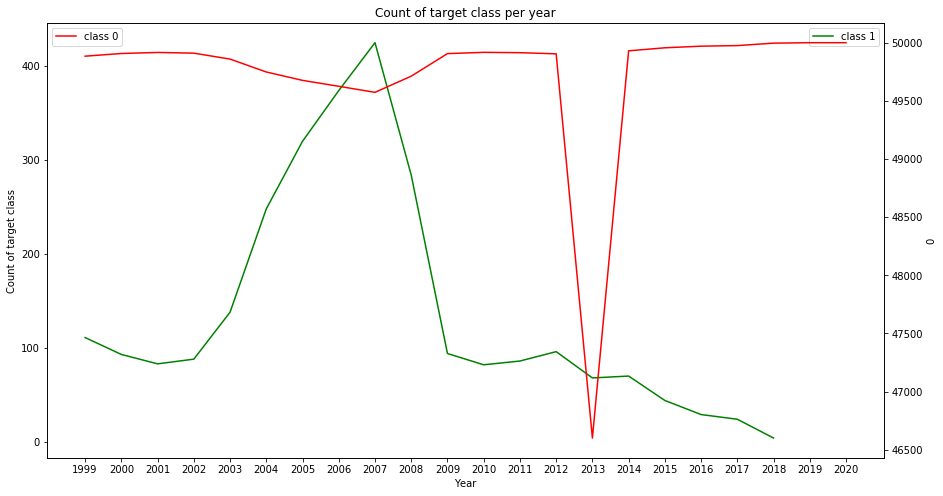

In [135]:
import seaborn as sns
plt.figure(figsize=(15, 8))
ax1 = sns.lineplot(data=df_ty,x='Year',y=1, color="g")
ax2 = plt.twinx()
sns.lineplot(data=df_ty,x='Year',y=0, color="r")

plt.xticks(np.arange(min(df_ty['Year']), max(df_ty['Year'])+1, 1.0))
ax1.legend(labels=['class 1'])
ax2.legend(labels=['class 0'])
ax1.set_title("Count of target class per year")
ax1.set_ylabel("Count of target class")
plt.show()

We will analyze 2007 specifically

In [137]:
df_partial = df[df['Year'].isin([2007])].reset_index()
df_partial

,index,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,...,loan_purpose,orig_loan_term,cnt_borr,flag_sc,indicator,harp_indicator,property_method,interest_only,Year,loss_target
0,399980,769,200702,1,203701,156,0.0,1.0,1,90,...,3,360,2,0,0,0,9,0,2007,0
1,399981,598,200703,1,203702,0,0.0,1.0,1,90,...,3,360,2,0,0,0,9,0,2007,0
2,399982,777,200703,1,203702,115,0.0,1.0,1,75,...,3,360,2,0,0,0,9,0,2007,0
3,399983,628,200703,1,203702,282,0.0,1.0,1,65,...,3,360,2,0,0,0,9,0,2007,0
4,399984,651,200703,1,203702,0,0.0,1.0,1,75,...,2,360,2,0,0,0,9,0,2007,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,449973,727,201002,1,203811,428,30.0,1.0,1,80,...,3,346,2,0,0,0,9,0,2007,0
49994,449974,759,200712,1,203711,0,0.0,1.0,1,60,...,3,360,2,0,0,0,9,0,2007,0
49995,449975,711,200712,2,203711,83,0.0,1.0,1,80,...,3,360,1,0,0,0,9,0,2007,0
49996,449976,639,200802,2,203801,23,0.0,1.0,1,100,...,3,360,1,0,0,0,9,0,2007,0


#### UPB

In [182]:
x = df_partial['fico']
Y = df_partial['orig_upb']
events = explain_anomalies(y=Y, window_size=12, sigma=3)

# Display the anomaly dict
print("Information about the anomalies model:{}".format(events))

Information about the anomalies model:{'standard_deviation': 78669.671, 'anomalies_dict': OrderedDict([(65, 536000), (79, 417000), (96, 415000), (397, 415000), (1272, 417000), (1376, 402000), (1480, 417000), (1980, 415000), (2009, 417000), (2399, 417000), (2443, 415000), (2491, 407000), (2534, 447000), (2737, 417000), (2744, 406000), (2933, 417000), (2977, 384000), (2987, 417000), (3044, 400000), (3434, 376000), (4059, 400000), (4284, 520000), (4542, 417000), (4613, 488000), (4748, 413000), (4900, 590000), (5198, 600000), (5409, 534000), (5577, 417000), (5631, 533000), (6132, 568000), (6346, 438000), (6924, 540000), (7189, 520000), (7273, 417000), (8177, 495000), (8256, 417000), (8327, 417000), (8470, 417000), (8753, 452000), (9182, 400000), (9236, 520000), (9263, 577000), (9406, 417000), (9728, 533000), (10196, 518000), (10419, 417000), (10578, 540000), (10678, 403000), (10922, 571000), (11000, 417000), (11189, 400000), (11271, 400000), (11279, 456000), (11302, 475000), (11411, 417000

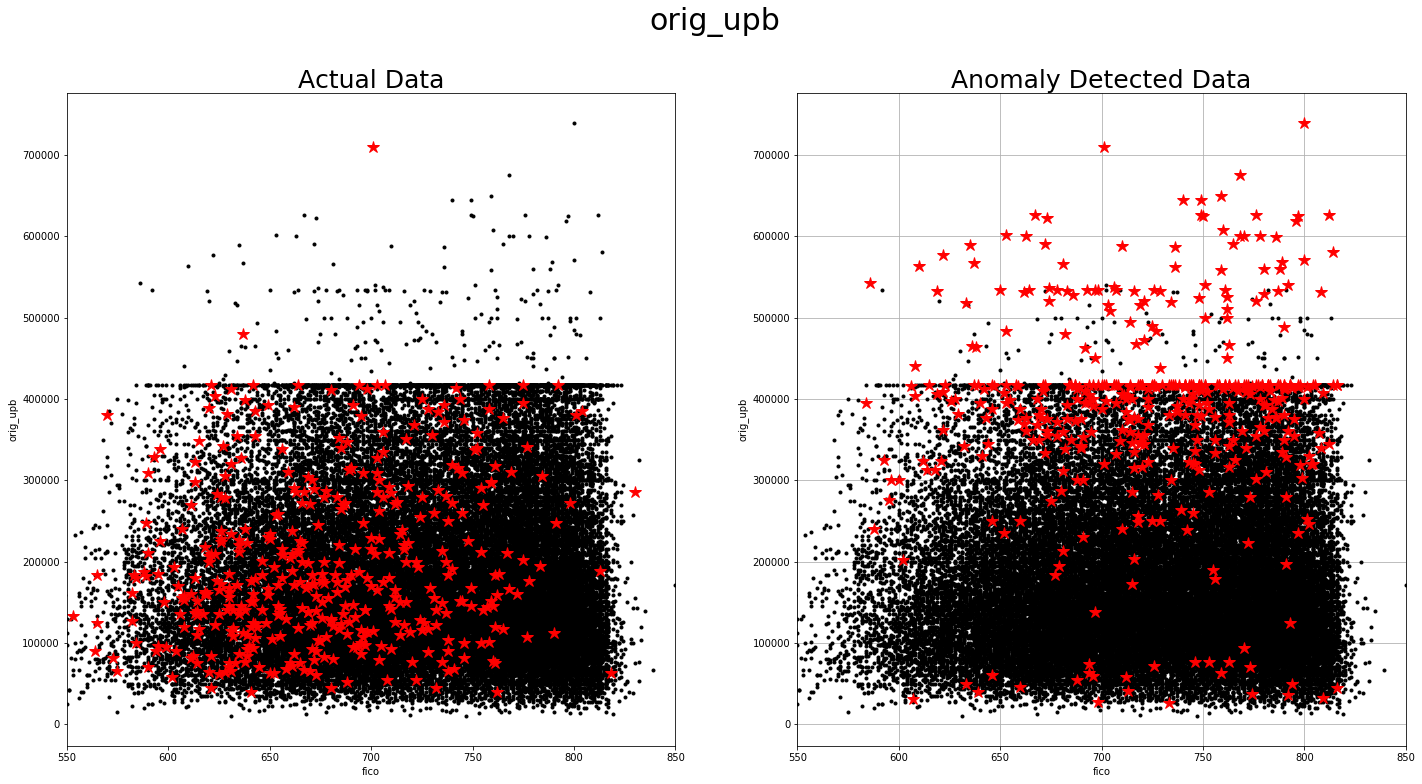

In [193]:
plot_compare(x='fico', y='orig_upb', df=df_partial,window_size=70, text_xlabel=x.name, sigma_value=3,
             text_ylabel=Y.name,applying_rolling_std=True,xlim=550,ylim=850)


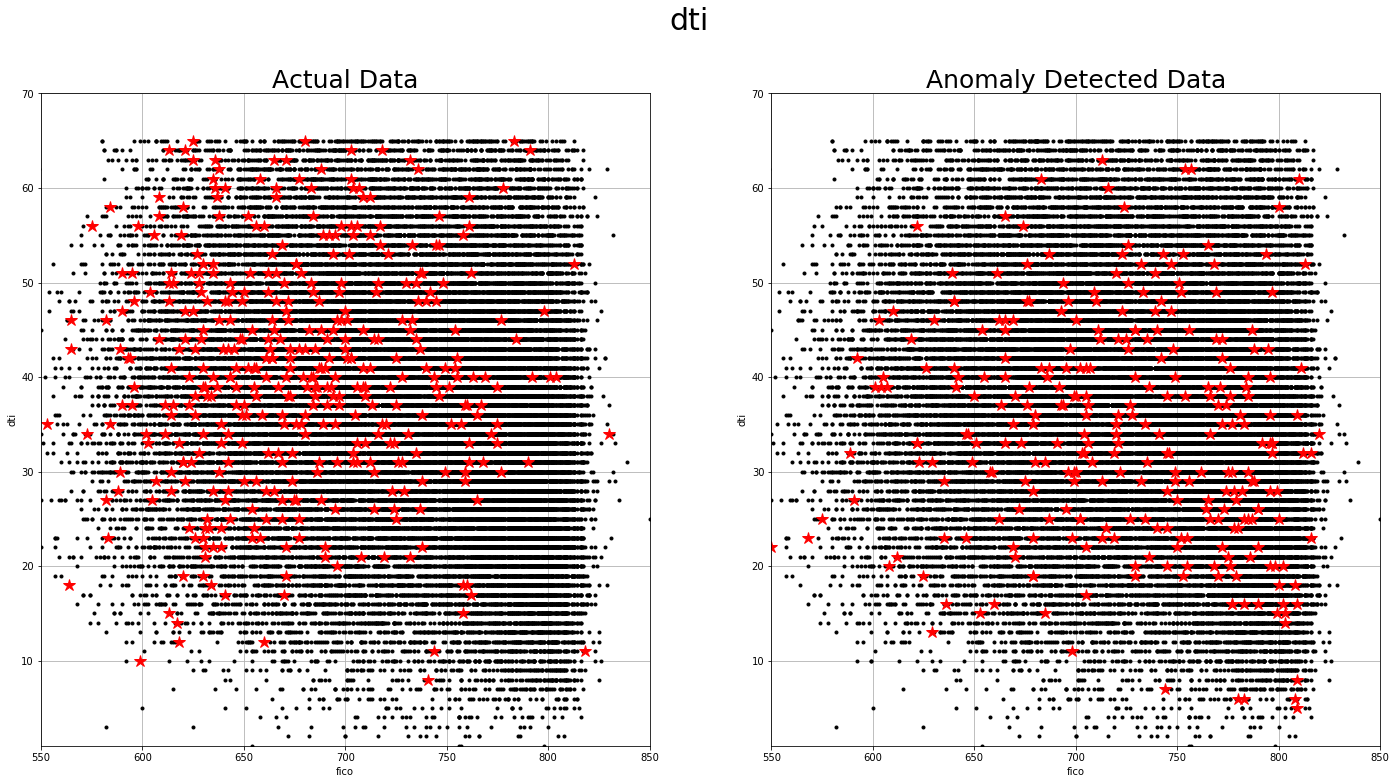

In [223]:
L_Y = ['dti','ltv','orig_loan_term','mi_pct']
Y = df_partial['dti']
plot_compare(x='fico', y=Y.name, df=df_partial,window_size=10, text_xlabel=x.name, sigma_value=3,
             text_ylabel=Y.name,applying_rolling_std=True,xlim1=550,xlim2=850,ylim1=1,ylim2=70)

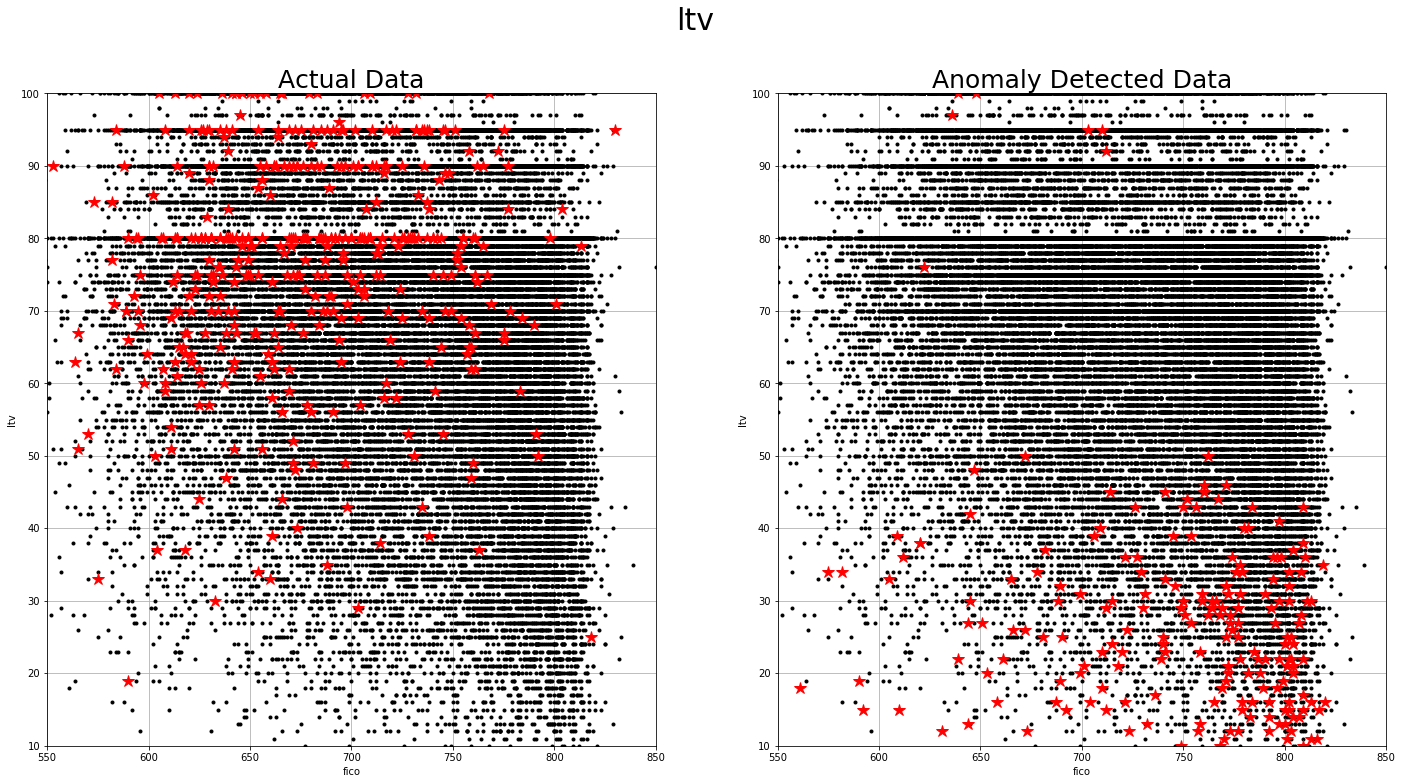

In [235]:
Y = df_partial['ltv']
plot_compare(x='fico', y=Y.name, df=df_partial,window_size=20, text_xlabel=x.name, sigma_value=3,
             text_ylabel=Y.name,applying_rolling_std=True,xlim1=550,xlim2=850,ylim1=10,ylim2=100)

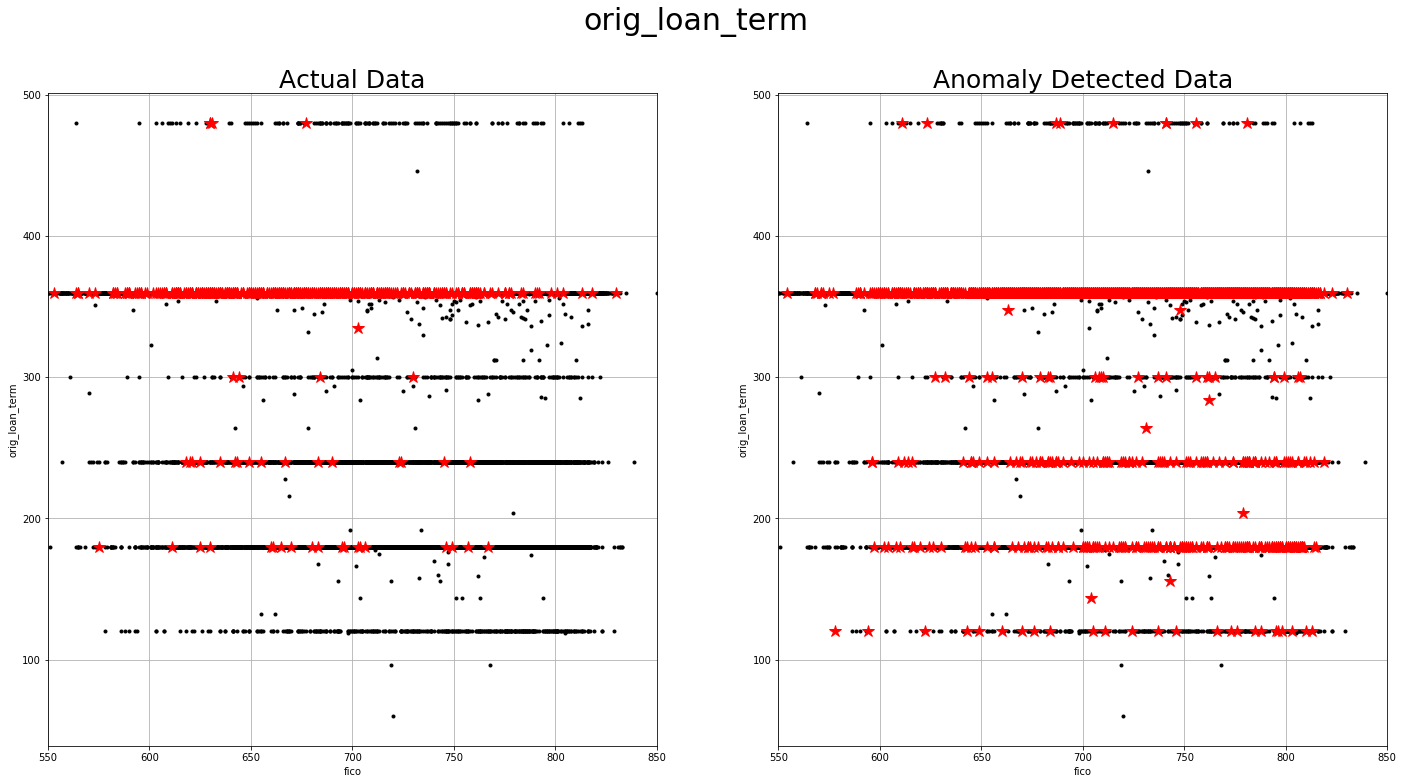

In [258]:
Y = df_partial['orig_loan_term']
plot_compare(x='fico', y=Y.name, df=df_partial,window_size=70, text_xlabel=x.name, sigma_value=5,
             text_ylabel=Y.name,applying_rolling_std=True,xlim1=550,xlim2=850)

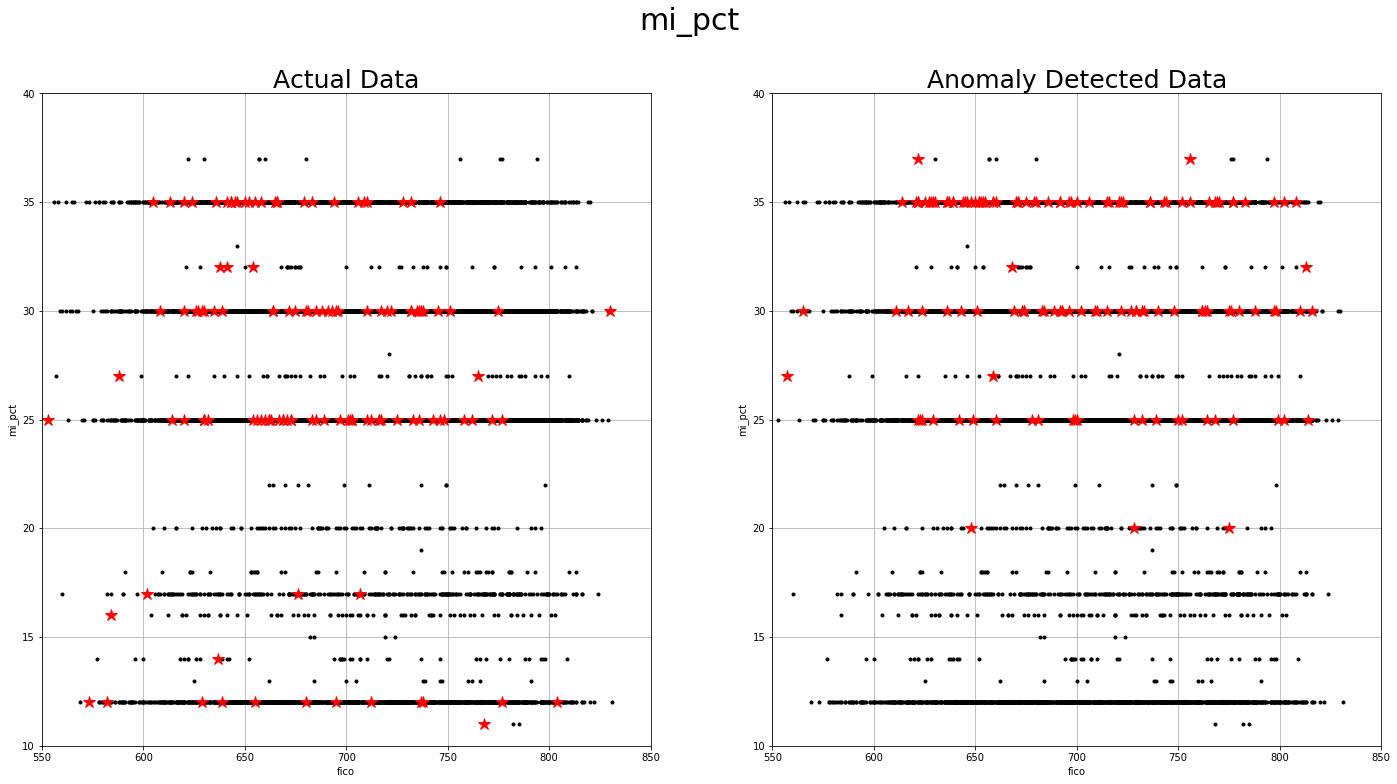

In [264]:
Y = df_partial['mi_pct']
plot_compare(x='fico', y=Y.name, df=df_partial,window_size=100, text_xlabel=x.name, sigma_value=4,
             text_ylabel=Y.name,applying_rolling_std=True,xlim1=550,xlim2=850,ylim1=10,ylim2=40)

In [262]:
##